In [9]:
import os
import sys
import time as t_util
import numpy as np
import cftime
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import mplotutils as mpu
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [10]:
#Read main path
with open('../path_main.txt', 'r') as file:    path_main = file.read()

dir_data = f'{path_main}Data/'
dir_fig  = f'{path_main}Figures/Paper_v2/'
dir_repo = f'{path_main}Data/RepositoryPublication/'
if not os.path.exists(dir_fig): os.mkdir(dir_fig)
    

## Plot (4 ensembles)

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be remove

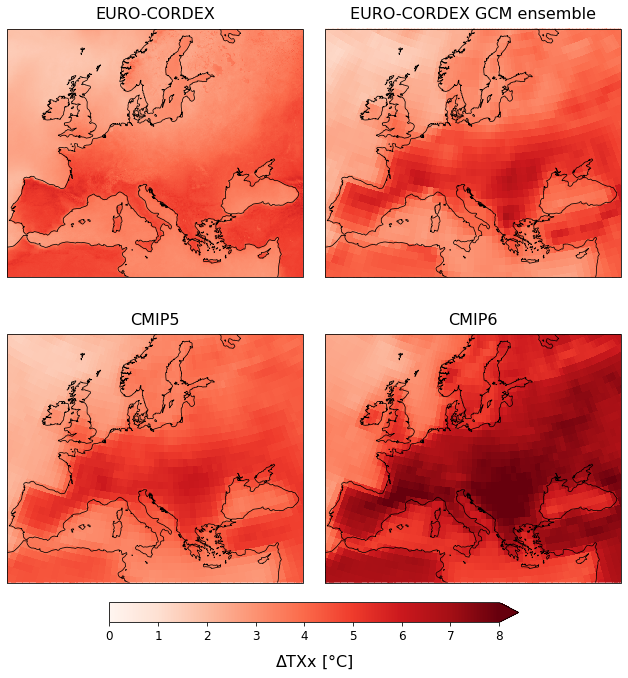

In [11]:
#Define variable
variab = 'TXx'

#Define model sets
model_sets = ['EURO-CORDEX', 'CMIP5-CORDEX', 'CMIP5', 'CMIP6']

#Create figure
fig, axes = plt.subplots(2, 2, figsize=(11, 10.5), subplot_kw=dict(projection=ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.075)
plt.subplots_adjust(hspace=0.15)

#Define limits
limits = dict()
limits['EURO-CORDEX']  = [0, 8]
limits['CMIP6']        = [0, 8]
limits['CMIP5']        = [0, 8]
limits['CMIP5-CORDEX'] = [0, 8]

#Loop over model sets
collect_data = dict()
for i1, model_set in enumerate(model_sets):
    
    ax = axes[i1]
    
    #Skip TNx for CMIP5 since data are not available for all models
    if model_set=='CMIP5' and variab=='TNx':
        continue    

    #Read data
    if model_set=='CMIP5-CORDEX':
        dir_files = dir_data + 'CMIP5/Yearmax/'
        fname     = dir_files + variab + '_CMIP5-CORDEX-ensemble_all_models_yearmax.nc'
        title = 'EURO-CORDEX GCM ensemble'
    else:
        dir_files = dir_data + model_set + '/Yearmax/'
        fname     = dir_files + variab + '_all_models_yearmax.nc'
        title = model_set
    data  = xr.open_dataset(fname)
    
    #Add coastlines and set extent
    ax.coastlines(resolution='50m', linewidth=0.75, color='k')
    ax.set_extent([-7.5, 39, 33, 65], crs=ccrs.PlateCarree())
    
    #Select data
    val = data[variab].median('model')

    #Plot
    h1 = ax.pcolormesh(data.lon, data.lat, val, transform=ccrs.PlateCarree(), vmin=limits[model_set][0], vmax=limits[model_set][1], cmap='Reds')

    #Set title
    ax.set_title(title, fontsize=16, pad=10)

    #Collect data to save as NetCDF
    collect_data[model_set] = val
    
#Colorbar
cbar = mpu.colorbar(h1, axes[-2], axes[-1], orientation='horizontal', extend='max', size=0.08, shrink=1/3, pad=0.08)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$\Delta$' + variab + ' [°C]', fontsize=16, labelpad=10)

#Save in file
fig.savefig(dir_fig + 'FigS7_TX-changes_CORDEX_CMIP6_CMIP5_v2.png', dpi=300, bbox_inches='tight')


## Export data to excel NetCDF

In [4]:
#Define compression for output NetCDF file
comp = dict(zlib=True, complevel=3)

#Define scenarios
scenarios = dict()
scenarios['EURO-CORDEX'] = 'RCP85'
scenarios['CMIP5-CORDEX'] = 'RCP85'
scenarios['CMIP5'] = 'RCP85'
scenarios['CMIP6'] = 'SSP585'

#Define figure number
figs_out = dict()
figs_out['EURO-CORDEX'] = 'Fig1'
figs_out['CMIP5-CORDEX'] = 'FigS7'
figs_out['CMIP5'] = 'FigS7'
figs_out['CMIP6'] = 'FigS7'

#Loop over model sets
for model_set in model_sets:
    
    #Select data and convert to dataset
    data = collect_data[model_set]
    data = data.to_dataset(name=variab)
    
    #Add attributes for TXx
    data['TXx'].attrs['standard_name'] = 'Delta-TXx'
    data['TXx'].attrs['long_name']     = 'Change in annual maximum of daily maximum temperature'
    data['TXx'].attrs['units']         = 'K'

    #Get Figure number and scenario
    fig_out = figs_out[model_set]
    scen    = scenarios[model_set]
    
    #Define output file name
    fname_out = dir_repo + 'Data_' + fig_out + '_DeltaTXx_' + model_set + '_1970-1999_to_2070-2099_' + scen + '.nc'
    if os.path.exists(fname_out):  os.remove(fname_out)

    #Save data as NetCDF
    data.to_netcdf(fname_out, encoding={var: comp for var in data.data_vars})
    